In [1]:
import sys
import os

# Adiciona o diretório raiz do projeto ao sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
from config import settings
from scripts.AutoClusterHPO import AutoClusterHPO
from scripts.PCATransformer import PCATransformer
from scripts.DataFrameFeatureSelector import DataFrameFeatureSelector 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f, pearsonr, chi2_contingency
from scipy.stats.contingency import association
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import math
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from scipy import stats

# Importe os novos modelos que você quer testar
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np

pd.options.display.float_format = '{:.2f}'.format

c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\hyperopt\atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


# Leitura dos Dados

In [3]:
df_pof_domicilio = pd.read_csv(settings.DADOS_CSV, sep=',')

# Pré-processamento

In [4]:
quanti_cols = ['Qtd de banheiros exclusivos',
 'Rendimento mensal mínimo geral (R$)', 'Qtd de cômodos',
 'Valor em reais (R$) do rendimento bruto',
 'Valor em reais (R$) de despesa individual',
 'Rendimento mensal mínimo p\\ alimentação (R$)',
 'Valor em reais (R$) de despesa coletiva']

quali_cols = ['A rua onde se localiza é pavimentada?', 'Situação do Domicílio',
 'A água é aquecida por energia elétrica?',
 'Utiliza-se lenha ou carvão na preparação de alimentos?',
 'Utiliza-se energia elétrica na preparação de alimentos?',
 'Material do telhado', 'Material do piso',
 'A água é aquecida por energia solar?',
 'Tipo de escoadouro sanitário',
 'A água é aquecida por lenha ou carvão?',
 'A água é aquecida por gás?', 'Tipo de chegada da água',
 'A água é aquecida por outra forma?',
 'O serviço de correios é realizado:', 'Tipo do domicílio']

# Inicializa o scaler
scaler = StandardScaler()

# 2. Separar features (X) e alvo (y)
X = df_pof_domicilio[quanti_cols + quali_cols]
y = scaler.fit_transform(df_pof_domicilio[['Aluguel Estimado']])

# 3. PRÉ-PROCESSAMENTO - Parte 1: One-Hot Encoding
# Aplicar em colunas categóricas para evitar multicolinearidade
X_encoded = pd.get_dummies(X, columns=df_pof_domicilio[quali_cols].columns, drop_first=True)

X_final = X_encoded.copy()

X_final[quanti_cols] = scaler.fit_transform(X_final[quanti_cols])

# Seleção de Modelos e Variáveis

In [ ]:
def calcular_cp_mallows(modelo_completo, X_completo, y, modelo_subconjunto, X_subconjunto):
    """
    Calcula o Cp de Mallows para um modelo de subconjunto.

    Args:
        modelo_completo (object): O objeto do modelo de regressão completo (já treinado).
        X_completo (np.array): Os dados de entrada (features) para o modelo completo.
        y (np.array): Os valores alvo (reais).
        modelo_subconjunto (object): O objeto do modelo de subconjunto (já treinado).
        X_subconjunto (np.array): Os dados de entrada (features) para o modelo de subconjunto.

    Returns:
        float: O valor do Cp de Mallows.
    """
    n = len(y)  # Número total de observações
    k = X_subconjunto.shape[1]  # Número de preditores no modelo de subconjunto
    p_completo = X_completo.shape[1] + 1  # Número de parâmetros no modelo completo (k + 1)

    # Previsões do modelo de subconjunto
    y_pred_subconjunto = modelo_subconjunto.predict(X_subconjunto)
    
    # 1. Calcular SQE_k (Soma dos Quadrados dos Erros para o subconjunto)
    sqe_k = np.sum((y - y_pred_subconjunto) ** 2)

    # 2. Calcular s^2 (Estimativa da variância do erro a partir do modelo COMPLETO)
    #    Isso é o Quadrado Médio do Erro (MSE) do modelo completo.
    y_pred_completo = modelo_completo.predict(X_completo)
    mse_completo = np.sum((y - y_pred_completo) ** 2) / (n - p_completo)
    s2 = mse_completo

    # 3. Aplicar a fórmula do Cp de Mallows
    # Cp = (SQE_k / s^2) + 2*(k+1) - n
    cp = (sqe_k / s2) + 2 * (k + 1) - n
    
    return cp

In [ ]:
# --- Assumindo que X_final, y e a função calcular_cp_mallows já existem ---

# Juntar X e y no dataframe final para o seletor
dataframe_final = X_final.copy()
dataframe_final['Aluguel Estimado'] = y

# 1. Crie um dicionário de modelos para testar
modelos_para_testar = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=50, random_state=42)
}

# 2. Crie um lugar para guardar todos os resultados
resultados_gerais = []

# 3. Loop principal: itere sobre cada modelo
for nome_modelo, modelo in modelos_para_testar.items():
    
    print(f"--- Iniciando Avaliação para o Modelo: {nome_modelo} ---")

    # Instancie o seletor com o modelo da iteração atual
    seletor = DataFrameFeatureSelector(
        model=modelo,
        dataframe=dataframe_final,
        target_column='Aluguel Estimado'
    )

    # Treine o modelo completo como referência PARA ESTE TIPO de modelo
    modelo_completo = modelo
    modelo_completo.fit(X_final, y)

    # O loop interno para testar as combinações de features permanece o mesmo
    for k in range(1, 15):
        print(f"Rodando forward com k={k} para {nome_modelo}...")
        seletor.run(method='forward', n_features_to_select=k, scoring='r2', cv=2)
            
        subset_cols = seletor.summary_['selected_features_list']
        X_subconjunto = X_final[subset_cols]
            
        # Treine o modelo de subconjunto
        # Para modelos como Ridge e Lasso, é importante usar uma nova instância
        modelo_subconjunto = type(modelo)() 
        modelo_subconjunto.set_params(**modelo.get_params()) # Copia os hiperparâmetros
        modelo_subconjunto.fit(X_subconjunto, y)
        y_pred = modelo_subconjunto.predict(X_subconjunto)

        r2 = modelo_subconjunto.score(X_subconjunto, y)
            
        """ 
        
        # O Cp de Mallows é mais indicado para modelos lineares.
        # Para outros modelos, ele pode ser calculado, mas sua interpretação é menos direta.
        # Uma opção é calculá-lo apenas para os modelos lineares.
        cp = np.nan # Valor padrão
        if nome_modelo in ['Linear Regression', 'Ridge', 'Lasso']:
            break 
            cp = calcular_cp_mallows(
                    modelo_completo=modelo_completo, 
                    X_completo=X_final, y=y, 
                    modelo_subconjunto=modelo_subconjunto, 
                    X_subconjunto=X_subconjunto
            )
            
        """
        
        resultados_gerais.append({
                'modelo': nome_modelo, # Adiciona o nome do modelo aos resultados
                'method': 'forward',
                'SQE': np.sum((y.ravel() - y_pred.ravel())**2),
                'r2': r2,
                'features': subset_cols,
                'k': len(subset_cols)
        })

print("Avaliação geral concluída!")

# Converta os resultados para um DataFrame para facilitar a análise
resultados_df = pd.DataFrame(resultados_gerais)

In [39]:
resultados_df

,modelo,method,SQE,r2,features,k
0,Linear Regression,forward,31984.61,0.31,[Rendimento mensal mínimo geral (R$)],1
1,Linear Regression,forward,26223.76,0.43,"[Qtd de banheiros exclusivos, Rendimento mensa...",2
2,Linear Regression,forward,24383.42,0.47,"[Qtd de banheiros exclusivos, Rendimento mensa...",3
3,Linear Regression,forward,22595.04,0.51,"[Qtd de banheiros exclusivos, Rendimento mensa...",4
4,Linear Regression,forward,21884.68,0.53,"[Qtd de banheiros exclusivos, Rendimento mensa...",5
5,Linear Regression,forward,21381.24,0.54,"[Qtd de banheiros exclusivos, Rendimento mensa...",6
6,Linear Regression,forward,21042.55,0.55,"[Qtd de banheiros exclusivos, Rendimento mensa...",7
7,Linear Regression,forward,20766.91,0.55,"[Qtd de banheiros exclusivos, Rendimento mensa...",8
8,Linear Regression,forward,20617.21,0.55,"[Qtd de banheiros exclusivos, Rendimento mensa...",9
9,Linear Regression,forward,20599.73,0.56,"[Qtd de banheiros exclusivos, Rendimento mensa...",10


In [40]:
resultados_df.loc[23, 'features']

['Qtd de banheiros exclusivos',
 'Rendimento mensal mínimo geral (R$)',
 'A água é aquecida por energia elétrica?_Sim',
 'Material do telhado_Outro material',
 'Material do telhado_Telha sem laje de concreto',
 'Material do piso_Cimento',
 'Tipo de escoadouro sanitário_Rede geral, rede pluvial ou fossa ligada à rede',
 'A água é aquecida por lenha ou carvão?_Sim',
 'A água é aquecida por gás?_Sim',
 'Tipo do domicílio_Casa']

<Axes: xlabel='k', ylabel='SQE'>

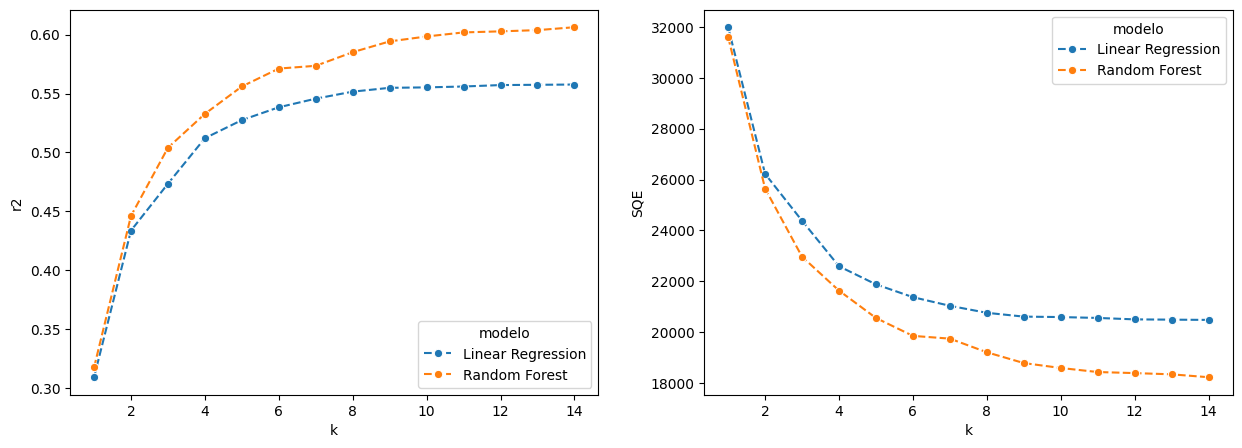

In [35]:
# Crie uma grade 2x2 para ter espaço para 3 ou 4 gráficos
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.lineplot(
    data=resultados_df, 
    x='k', 
    y='r2', 
    hue='modelo',
    marker='o',       # Adiciona marcadores de círculo
    linestyle='--',  # Define o estilo da linha 
    ax=ax[0]             # Diz ao Seaborn para desenhar neste eixo específico
)

sns.lineplot(
    data=resultados_df, 
    x='k', 
    y='SQE', 
    hue='modelo',
    marker='o',       # Adiciona marcadores de círculo
    linestyle='--',  # Define o estilo da linha 
    ax=ax[1]             # Diz ao Seaborn para desenhar neste eixo específico
)

# Modelagem

In [5]:
cols = ['Qtd de banheiros exclusivos',
 'Rendimento mensal mínimo geral (R$)',
 'A água é aquecida por energia elétrica?_Sim',
 'Material do telhado_Outro material',
 'Material do telhado_Telha sem laje de concreto',
 'Material do piso_Cimento',
 'Tipo de escoadouro sanitário_Rede geral, rede pluvial ou fossa ligada à rede',
 'A água é aquecida por lenha ou carvão?_Sim',
 'A água é aquecida por gás?_Sim',
 'Tipo do domicílio_Casa']

X_train, X_test, y_train, y_test = train_test_split(X_final[cols], y, test_size=0.3, random_state=42)

# Criar uma instância do modelo de Regressão Linear
modelo = LinearRegression()

# 5. Treinar o modelo com os dados de treino
modelo.fit(X_train, y_train)

# 6. Fazer previsões nos dados de teste
y_pred = modelo.predict(X_test)

# 7. Avaliar a performance do modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 8. Exibir os resultados
print("--- Resultados da Avaliação ---")
print(f"Erro Quadrático Médio (MSE): {mse:.2f}")
print(f"Coeficiente de Determinação (R²): {r2:.2f}")
print("-" * 30)

# 7. CALCULAR RESÍDUOS E PREVISÕES DO CONJUNTO DE TREINO (ESSENCIAL PARA OS TESTES)
print("\nCalculando resíduos do conjunto de treino para verificação das suposições...")
valores_previstos_treino = modelo.predict(X_train)
residuos_treino = y_train - valores_previstos_treino

--- Resultados da Avaliação ---
Erro Quadrático Médio (MSE): 0.46
Coeficiente de Determinação (R²): 0.54
------------------------------

Calculando resíduos do conjunto de treino para verificação das suposições...


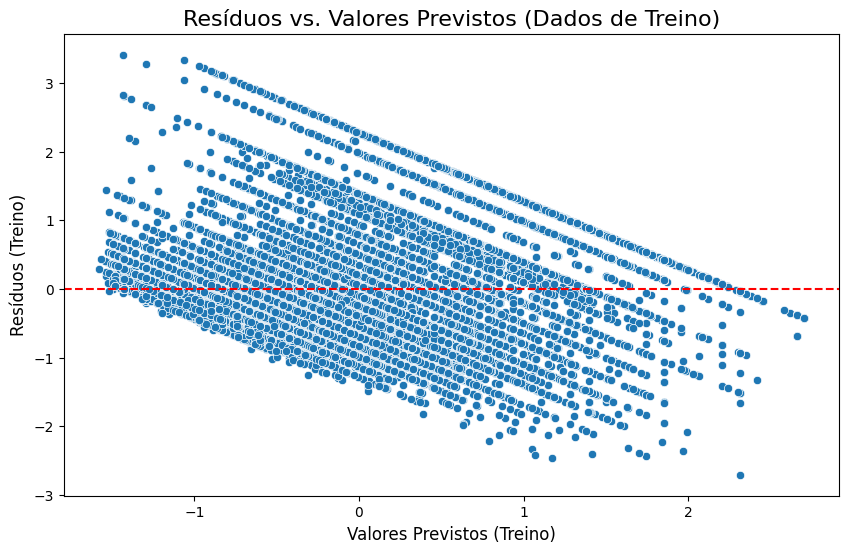

In [16]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=valores_previstos_treino.squeeze(), y=residuos_treino.squeeze())
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Resíduos vs. Valores Previstos (Dados de Treino)', fontsize=16)
plt.xlabel('Valores Previstos (Treino)', fontsize=12)
plt.ylabel('Resíduos (Treino)', fontsize=12)
plt.show()

## Suposição: Normalidade dos Residuos

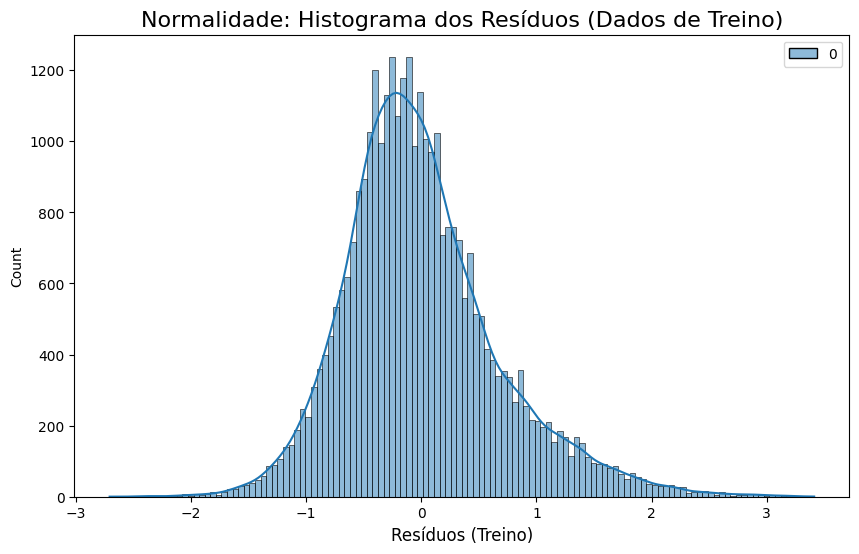

In [11]:
# Histograma
plt.figure(figsize=(10, 6))
sns.histplot(residuos_treino, kde=True)
plt.title('Normalidade: Histograma dos Resíduos (Dados de Treino)', fontsize=16)
plt.xlabel('Resíduos (Treino)', fontsize=12)
plt.show()

In [7]:
shapiro_test = stats.shapiro(residuos_treino)
print(f'Teste de Shapiro-Wilk (treino): Estatística={shapiro_test.statistic:.4f}, p-valor={shapiro_test.pvalue:.4f}')
if shapiro_test.pvalue < 0.05:
    print("Resultado: Os resíduos não parecem ser normalmente distribuídos (p < 0.05).")
else:
    print("Resultado: Os resíduos parecem ser normalmente distribuídos (p >= 0.05).")

Teste de Shapiro-Wilk (treino): Estatística=0.9666, p-valor=0.0000
Resultado: Os resíduos não parecem ser normalmente distribuídos (p < 0.05).


## Suposição: Independencia dos Residuos

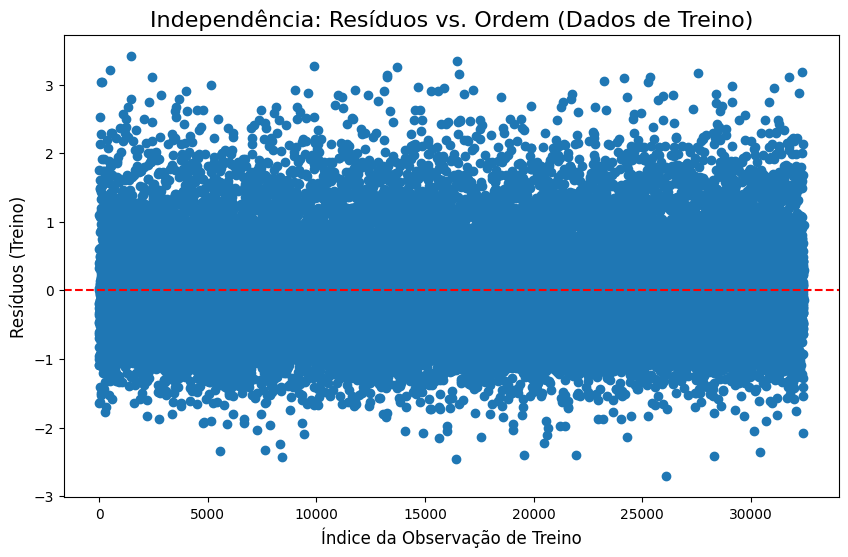

In [8]:
plt.figure(figsize=(10, 6))
# Usamos .reset_index() para garantir que o eixo x seja sequencial
residuos_df = pd.Series(residuos_treino.squeeze()).reset_index(drop=True)
plt.plot(residuos_df.index, residuos_df.values, marker='o', linestyle='')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Independência: Resíduos vs. Ordem (Dados de Treino)', fontsize=16)
plt.xlabel('Índice da Observação de Treino', fontsize=12)
plt.ylabel('Resíduos (Treino)', fontsize=12)
plt.show()

In [9]:
def durbin_watson_test(residuos):
    residuos_diff = np.diff(residuos, n=1)
    numerador = np.sum(residuos_diff**2)
    denominador = np.sum(residuos**2)
    return numerador / denominador

dw_stat = durbin_watson_test(residuos_treino.squeeze())
print(f'Estatística de Durbin-Watson (manual, treino): {dw_stat:.4f}')

Estatística de Durbin-Watson (manual, treino): 1.9927


## Suposição: Homocedasticidade (Variância Constante)

In [10]:
def breusch_pagan_test(residuos, X):
    n = len(residuos)
    k = X.shape[1]
    residuos_sq = residuos**2
    modelo_aux = LinearRegression()
    modelo_aux.fit(X, residuos_sq)
    r2_aux = modelo_aux.score(X, residuos_sq)
    lm_stat = n * r2_aux
    p_value = 1 - stats.chi2.cdf(lm_stat, df=k)
    return lm_stat, p_value

bp_stat, bp_p_value = breusch_pagan_test(residuos_treino.squeeze(), X_train)
print("Teste de Breusch-Pagan (Manual, treino):")
print(f"Estatística LM: {bp_stat:.4f}")
print(f"Valor-p: {bp_p_value:.4f}")
if bp_p_value < 0.05:
    print("Resultado: Há evidência de heterocedasticidade (p < 0.05).")
else:
    print("Resultado: Não há evidência de heterocedasticidade (p >= 0.05).")

Teste de Breusch-Pagan (Manual, treino):
Estatística LM: 889.4242
Valor-p: 0.0000
Resultado: Há evidência de heterocedasticidade (p < 0.05).


## Suposição: Ausência de Multicolinearidade

In [13]:
def calculate_vif(X_df):
    vif = pd.DataFrame()
    vif["feature"] = X_df.columns
    vif["VIF"] = [0.0] * len(X_df.columns)
    for i, feature in enumerate(X_df.columns):
        y_vif = X_df[feature]
        X_vif = X_df.drop(columns=[feature])
        model_vif = LinearRegression()
        model_vif.fit(X_vif, y_vif)
        r_squared_vif = model_vif.score(X_vif, y_vif)
        vif.loc[i, "VIF"] = 1 / (1 - r_squared_vif)
    return vif

vif_result = calculate_vif(X_train)
print("\nFator de Inflação de Variância (VIF) (Manual, treino):")
print(vif_result)


Fator de Inflação de Variância (VIF) (Manual, treino):
                                             feature  VIF
0                        Qtd de banheiros exclusivos 1.32
1                Rendimento mensal mínimo geral (R$) 1.39
2        A água é aquecida por energia elétrica?_Sim 1.20
3                 Material do telhado_Outro material 1.04
4     Material do telhado_Telha sem laje de concreto 1.37
5                           Material do piso_Cimento 1.19
6  Tipo de escoadouro sanitário_Rede geral, rede ... 1.27
7         A água é aquecida por lenha ou carvão?_Sim 1.05
8                     A água é aquecida por gás?_Sim 1.07
9                             Tipo do domicílio_Casa 1.16
